In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Set the default plot aesthetics to be prettier.
sns.set_style("white")

In [16]:
# Loading the data again.

df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv")

# Take a subset of the data to make plots clearer.
print(df.head())

print(df.cntry.unique())

  cntry  idno  year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  \
0    CH   5.0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   
1    CH  25.0     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   
2    CH  26.0     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   
3    CH  28.0     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   
4    CH  29.0     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   

   gndr  agea  partner  
0   2.0  60.0      1.0  
1   2.0  59.0      1.0  
2   1.0  24.0      2.0  
3   2.0  64.0      1.0  
4   2.0  55.0      1.0  
['CH' 'CZ' 'DE' 'ES' 'NO' 'SE']


In [17]:
# Making dummies.
# Also creating a data frame to hold our features.
features = pd.get_dummies(df['cntry'])

# Nordic countries dummy.
features['Nordic'] = np.where((df['cntry'].isin(['NO', 'SE'])), 1, 0)

print(pd.crosstab(features['Nordic'], df['cntry']))

cntry     CH    CZ  DE    ES    NO    SE
Nordic                                  
0       1546  1316  28  2426     0     0
1          0     0   0     0  1462  1816


In [18]:
features['Adult_65plus'] = np.where(df['agea']>=65, 1, 0)

# Check to make sure it worked.
print(df['agea'].groupby(features['Adult_65plus']).describe())

               count       mean        std   min   25%   50%   75%    max
Adult_65plus                                                             
0             6682.0  40.874738  13.958596  15.0  29.0  42.0  53.0   64.0
1             1673.0  73.815302   6.650086  65.0  69.0  72.0  78.0  114.0


## TLADS Drill

Categorize each of the variables in the ESS dataset as categorical or continuous, and if continuous as ordinal, interval, or ratio variables.  Check your work with your mentor, and discuss what that information might imply for feature engineering with this data.

country - categorical

idno - continuous, ordinal

year - continuous, interval

tvtot - continuous, ratio

ppltrst - continuous, ratio

pplfair - continuous, ratio

happy - continuous, ratio

sclmeet - continuous, ratio

sclact - continuous, ratio

gndr - categorical

agea - continuous, ratio

partner - categorical

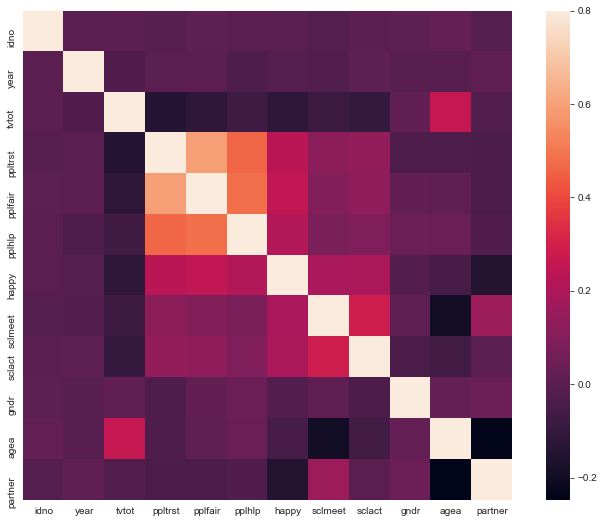

                  ppltrst   pplfair    pplhlp  trust_fair_help
ppltrst          1.000000  0.592001  0.462562         0.834209
pplfair          0.592001  1.000000  0.480918         0.841674
pplhlp           0.462562  0.480918  1.000000         0.789318
trust_fair_help  0.834209  0.841674  0.789318         1.000000


In [19]:
corrmat = df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Looks like 'pplfair','ppltrst' and 'pplhlp' are pretty redundant with each
# other. Let's make some averages. Just in case some of the variables are on
# different scales than others (one ranges from 0 to 100, one ranges from 0 to
# 7, for example) we scale them before averaging by subtracting the average of
# each variable from all values in that variable, then dividing by the
# standard deviation.
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
features['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

# Check how well the composite correlates with each of the individual variables.
plotdf = df.loc[:, ['ppltrst', 'pplfair', 'pplhlp']]
plotdf['trust_fair_help'] = features['trust_fair_help'] 
corrmat2 = plotdf.corr()

print(corrmat2)

In [ ]:
# Reverse-coding the 'happy' variable so that higher scores mean less
# happiness (and thus possibly more sadness).

features['Sadness'] = max(df['happy']) - df['happy']

sns.regplot(
    df['tvtot'],
    features['Sadness'],
    x_jitter=.49,
    y_jitter=.49,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.xlabel('TV watching')
plt.ylabel('Sadness')
plt.show()

In [ ]:
# If this is the first time you're using scikit-learn you'll first want to do
# pip install sklearn from your terminal to install the package.
from sklearn import preprocessing

# Select only numeric variables to scale.
df_num = df.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)

# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['tvtot'], df_scaled['tvtot'])
plt.show()

# Lookit all those matching means and standard deviations!
print(df_scaled.describe())

In [ ]:
# Create a better indicator for 'partner.' Currently it is coded 1 for
# living with a partner and 2 for not living with a partner.
features['LiveWithPartner'] = np.where(df['partner'] == 1, 1, 0)

# Create the interaction.
features['Sad_Partner'] = features['Sadness'] * features['LiveWithPartner']

# A plot of an interaction.
# Add the 'tvtot' feature to the features data frame for plotting.
features['tvtot'] = df['tvtot']
sns.lmplot(
    x='Sadness',
    y='tvtot',
    hue='LiveWithPartner',
    data=features,
    scatter=False
)
plt.show()